In [295]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [296]:
import numpy as np
import pandas as pd

In [297]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [298]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float, and_, Date, desc, func

In [299]:
#creates engine conn to hawaii sqlite 
engine = create_engine("sqlite:///C:/Users/skavy/Desktop/Bootcamp/AdvancedData/hawaii.sqlite")

In [300]:
# reflects an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [301]:
# views all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [302]:
# Saves references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [303]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

datetime.datetime(2016, 8, 23, 0, 0)

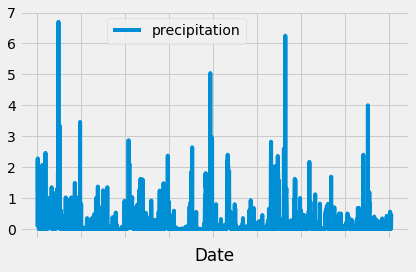

In [332]:
# query to retrieve the last 12 months of precipitation data and plot the results
first_entry=session.query(Measurement.date).order_by(Measurement.date).first().date
last_entry=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculates the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_entry, '%Y-%m-%d') - dt.timedelta(days=365)
last_year

# query to retrieve the data and precipitation scores
p_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()
p_scores
# Saves the query results as a Pandas DataFrame and set the index to the date column
results = pd.DataFrame(p_scores).dropna()
results.set_index('date',inplace=True)

# Sorts the dataframe by date
results.sort_values(by=['date'])

# Plotting with Matplotlib to plot the data
results.plot(x_compat=True)
plt.xlabel("Date")
plt.legend(["precipitation"],bbox_to_anchor=(0.60, 1.00))
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [305]:
# gets the summary statistics for the precipitation data
results.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [306]:
#query to calculate the total number of stations.
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

9

In [307]:
# gets most active stations? (i.e. what stations have the most rows)? the counts in descending order.
active_stations=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                                  order_by (func.count(Measurement.station).desc()).all(),columns=["Station ID","Observations"])

active_stations


,Station ID,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [308]:
#Gets the most active station i.e station with highest tobs
most_active_station = session.query(Measurement.station).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).limit(1).scalar()
print (str(most_active_station) + " Station has the highest number of observations.")

USC00519281 Station has the highest number of observations.


In [309]:
#calculates the lowest temperature ,highest temperature, and average temperature for most active station
temp_stats = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
session.query(*temp_stats).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

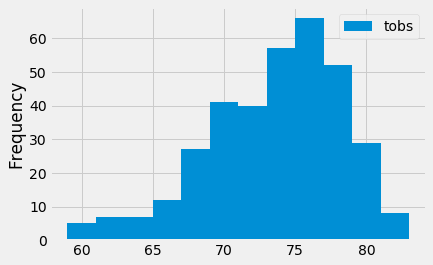

In [310]:
# Queries the last 12 months of temperature observation data for most active station
recent_temp = session.query(Measurement.date,Measurement.tobs).\
filter(and_(Measurement.station==most_active_station,Measurement.date >= last_year)).\
order_by(Measurement.date.desc()).all()
df=pd.DataFrame(recent_temp)

# plotting the df as a histogram
plt.hist(df['tobs'],bins=12,label='tobs')
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.show()

In [311]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [312]:
# calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
trip_startdate = dt.date(2019, 5, 1)
trip_enddate = dt.date(2019, 5, 10)
prev_year = dt.timedelta(days=365*2)
prev_year_stats = (calc_temps((trip_startdate-prev_year), (trip_enddate-prev_year)))
print(prev_year_stats)

[(65.0, 75.12280701754386, 80.0)]


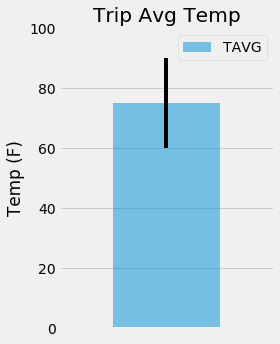

In [313]:

#Creates a dataframe with the calculated tmin, tavg, and tmax values
trip_df = pd.DataFrame(prev_year_stats, columns=['TMIN', 'TAVG', 'TMAX'])
# Plot the results from your previous query as a bar chart.
max = trip_df['TMAX']
min = trip_df['TMIN']

# Plotting the results from previous query as a bar chart. 
trip_df.plot.bar(y='TAVG', yerr=(max-min), alpha=0.5, figsize=(4,5))

# Using "Trip Avg Temp" as Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.tight_layout()
plt.ylim([0, 100])
plt.show()


In [314]:
# Calculates the total amount of rainfall per weather station for your trip dates using the previous year's matching dates in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    rain_stats = [Measurement.station, 
                  Measurement.prcp,
                  Station.name,
                  Station.latitude, 
                  Station.longitude, 
                  Station.elevation]
    
    return session.query(*rain_stats).\
            filter(Station.station==Measurement.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-05-01','2017-05-10'))


[('USC00519397', 0.26, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00516128', 0.25, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', 0.13, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00513117', 0.07, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519523', 0.07, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00514830', 0.03, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]


## Optional Challenge Assignment

In [315]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [316]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
def daily_normals(date):
    month = date.strftime('%m')
    day = date.strftime('%d')
    
    # gets the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ month + "-" + day)).all()
    t_max = max_temp[0][0]
    
    # gets the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ month + "-" + day)).all()
    t_min = min_temp[0][0]
    
    # gets the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date.like("%%%%-"+ month + "-" + day)).all()
    t_avg = avg_temp[0][0]
    
    return t_min,t_max,t_avg

# get the range of dates for the chart
start = trip_startdate
day_incr = dt.timedelta(days=1)
day_range = []
while start <= trip_enddate:
    day_range.append(start)
    start += day_incr

# get the max/min/avg of each day
temps = []
day_data = {}

# get the max/min/avg for each day using a for loop, store in dict
for date in day_range:
    min,max,avg = daily_normals(date)
    temps.append({"Date": date,"tmin": min,"tmax": max, "tavg":avg})
print(temps)

[{'Date': datetime.date(2019, 5, 1), 'tmin': 65.0, 'tmax': 79.0, 'tavg': 72.75925925925925}, {'Date': datetime.date(2019, 5, 2), 'tmin': 65.0, 'tmax': 79.0, 'tavg': 73.05084745762711}, {'Date': datetime.date(2019, 5, 3), 'tmin': 67.0, 'tmax': 84.0, 'tavg': 73.41071428571429}, {'Date': datetime.date(2019, 5, 4), 'tmin': 65.0, 'tmax': 78.0, 'tavg': 73.59649122807018}, {'Date': datetime.date(2019, 5, 5), 'tmin': 67.0, 'tmax': 79.0, 'tavg': 73.39655172413794}, {'Date': datetime.date(2019, 5, 6), 'tmin': 66.0, 'tmax': 80.0, 'tavg': 73.14035087719299}, {'Date': datetime.date(2019, 5, 7), 'tmin': 64.0, 'tmax': 79.0, 'tavg': 71.78846153846153}, {'Date': datetime.date(2019, 5, 8), 'tmin': 65.0, 'tmax': 80.0, 'tavg': 72.18867924528301}, {'Date': datetime.date(2019, 5, 9), 'tmin': 67.0, 'tmax': 79.0, 'tavg': 72.9322033898305}, {'Date': datetime.date(2019, 5, 10), 'tmin': 64.0, 'tmax': 78.0, 'tavg': 73.3157894736842}]


In [317]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals= pd.DataFrame(temps,columns=['Date','tmin', 'tavg', 'tmax'])
daily_normals

,Date,tmin,tavg,tmax
0,2019-05-01,65.0,72.759259,79.0
1,2019-05-02,65.0,73.050847,79.0
2,2019-05-03,67.0,73.410714,84.0
3,2019-05-04,65.0,73.596491,78.0
4,2019-05-05,67.0,73.396552,79.0
5,2019-05-06,66.0,73.140351,80.0
6,2019-05-07,64.0,71.788462,79.0
7,2019-05-08,65.0,72.188679,80.0
8,2019-05-09,67.0,72.932203,79.0
9,2019-05-10,64.0,73.315789,78.0


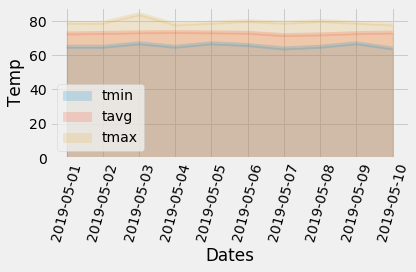

In [322]:
# Plots the daily normals as an area plot with `stacked=False`
ax=daily_normals.plot(kind='area', alpha=0.2, stacked=False)
#labelling x & y Axes
plt.xlabel("Dates")
plt.ylabel("Temp")
#setting ticks
ax.set_xticks(range(len(daily_normals)))
ax.set_xticklabels(daily_normals["Date"],rotation = 75)
plt.tight_layout()
plt.show()